In [ ]:
#@title Install Required Packages
!pip install seaborn==0.10.0
!pip install scanpy[leiden]


     |████████████████████████████████| 225kB 12.7MB/s 
  Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0
     |████████████████████████████████| 7.7MB 9.1MB/s 
     |████████████████████████████████| 122kB 51.8MB/s 
     |████████████████████████████████| 2.4MB 64.8MB/s 
     |████████████████████████████████| 3.2MB 44.4MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp36-none-any.whl size=7018 sha256=6b3f3b1552af96f7cce0db09fc516e891b53da77a9beb7435779a6f0a9805dd5
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo


In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


# scRNA-seq Data Analysis



In the lecture notebook we performed normalization on the CITE-Seq data from cord blood mononuclear cells (CBMC), clustered the cells based on their expression profiles, and assigned identity based on differentially expressed genes. Here, I will perform similar analysis, following the paper by [Granja _et al._](https://doi.org/10.1038/s41587-019-0332-7). The data set contains 53,638 cells from bone marrow (BMMCs), peripheral blood (PBMCs), and mixed-phenotype acute leukemias (MPALs). The data is also available in GEO under accession number [GSE139369](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139369).

The data has been aggregated and uploaded to the shared folder:

* [gse139369_scrna](https://drive.google.com/drive/folders/10bvCFSIzyjEykx-oDOdCizI44HdXCFWo?usp=sharing) : scRNASeq data

* [gse139369_scadt](https://drive.google.com/drive/folders/1-eq_MbDh6uSzZw-p4_bxliVGeshqw8od?usp=sharing) : Protein expression data

The data is stored into a directory with several files: 

* `barcodes.tsv`: A list of barcodes. Each barcode rpresents one unique cell 
* `genes.tsv`: A list of gene names and ensemble IDs
* `matrix.mtx`: A sparse matrix where each row is a cell, and each column is a gene

This is the standard storing format for data generated by 10X genomics machines. I will use a `scanpy` function to load these three files into `AnnData` object in one command called `read_10x_mtx`.

In [ ]:
import pandas as pd
from pathlib import Path
import scanpy as sc
import numpy as np

# set scanpy plotting parameter to dpi = 150
sc.settings.set_figure_params(dpi=150)

# change this to where you save the data
DATA = Path("/content/drive/My Drive/Colab Notebooks")

In [ ]:
# Read the directory containing barcodes, genes, and matrix.mtx files
ge = sc.read_10x_mtx(DATA / "gse139369_scrna")

ge.shape

(53638, 20287)

In [ ]:
# Show individual gene name
ge.var_names

Index(['FAM138A', 'OR4F5', 'AL627309.1', 'OR4F29', 'OR4F16', 'FAM87B',
       'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11',
       ...
       'LSS', 'AP001468.1', 'MCM3AP-AS1', 'MCM3AP', 'YBEY', 'C21orf58', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=20287)

In [ ]:
# Show cell barcodes
ge.obs_names

Index(['BMMC_D1T1:AAACCCAAGATGCAGC-1', 'BMMC_D1T1:AAACCCACAAACTCGT-1',
       'BMMC_D1T1:AAACCCACAGTGTACT-1', 'BMMC_D1T1:AAACCCATCGCTATTT-1',
       'BMMC_D1T1:AAACGAACACCCAATA-1', 'BMMC_D1T1:AAACGAACAGCAGTCC-1',
       'BMMC_D1T1:AAACGAACATGACGAG-1', 'BMMC_D1T1:AAACGAATCAAGCCAT-1',
       'BMMC_D1T1:AAACGCTAGCCGTAAG-1', 'BMMC_D1T1:AAACGCTAGCTAAACA-1',
       ...
       'MPAL5R_T2:TTTCCTCTCACCGGGT-1', 'MPAL5R_T2:TTTCCTCTCCACGCAG-1',
       'MPAL5R_T2:TTTCCTCTCGGTCCGA-1', 'MPAL5R_T2:TTTGCGCTCAACACGT-1',
       'MPAL5R_T2:TTTGGTTAGGATGGTC-1', 'MPAL5R_T2:TTTGGTTTCAGAAATG-1',
       'MPAL5R_T2:TTTGGTTTCCTTGCCA-1', 'MPAL5R_T2:TTTGTCAAGGACAGCT-1',
       'MPAL5R_T2:TTTGTCACAGATGAGC-1', 'MPAL5R_T2:TTTGTCATCTCGTTTA-1'],
      dtype='object', length=53638)

In the `obs_names`, the cell barcodes have prefixes of the sample names such as `BMMC_D1T1`, `MPAL5R`, etc. This is the sample IDs where the cells came from. In the following analyses, I'll first look at the normal samples, then the Mixed Phenotype Acute Leukemia samples. All the leukemia samples have the string `MPAL` in it. Therefore, I'll use it to create a column indicating whether the sample is normal or cancer.

In [ ]:
# Create a column for sample ID
ge.obs["sample_id"] = [s.split(":")[0] for s in ge.obs_names]

# Use the sample ID to create a column indicating whether the sample is normal 
# or cancer
ge.obs["cancer"] = ge.obs.sample_id.str.contains("MPAL")

ge.obs.drop_duplicates()

sample_id  cancer
BMMC_D1T1:AAACCCAAGATGCAGC-1  BMMC_D1T1   False
BMMC_D1T2:AAACCCACATGGCCAC-1  BMMC_D1T2   False
CD34_D2T1:AAACCTGAGTATCGAA-1  CD34_D2T1   False
CD34_D3T1:AAACCTGAGAAGGGTA-1  CD34_D3T1   False
PBMC_D4T1:AAACCCAAGATTGTGA-1  PBMC_D4T1   False
PBMC_D4T2:AAACCCAAGAAGTCAT-1  PBMC_D4T2   False
MPAL1_T1:AAAGATGAGCCACGCT-1    MPAL1_T1    True
MPAL1_T2:AAACCTGAGAAACGAG-1    MPAL1_T2    True
MPAL2_T1:AAACCTGAGCCCTAAT-1    MPAL2_T1    True
MPAL3_T1:AAACCTGCAACACCTA-1    MPAL3_T1    True
MPAL3_T2:AAACCTGCAATGGAAT-1    MPAL3_T2    True
MPAL4_T1:AAACCTGCAGCTTAAC-1    MPAL4_T1    True
MPAL4_T2:AAACCTGAGAATAGGG-1    MPAL4_T2    True
MPAL5_T1:AAACCTGCAATGGAAT-1    MPAL5_T1    True
MPAL5R_T1:AAACCTGAGTGTCCCG-1  MPAL5R_T1    True
MPAL5R_T2:AAACCTGCACCACCAG-1  MPAL5R_T2    True

## Cell type classification

For this assignment, I will focus on the cells coming from the cancer samples (`cancer==True`). In the original paper, the authors have done a lot of integrated analyses to understand the transcriptomic as well as regulatory profiles of the malignant cells in the MPAL samples. Here I'll simplify the analysis by trying to identify the malignant cells after eliminating the immune cells from the population.

First, I will perform several QC and normalization steps using `scanpy`. The author already did some cleaning to the data and therefore there are less steps to do; thus, the main steps that I will have to perform are:

1. Normalize the count to CP10K using `normalize_per_cell` with `counts_per_cell_after=1e4`
2. Log-normalize the CP10K values using `log1p`
3. Identify hgighly variable genes using `highly_variable_genes` with the following arguments: `min_mean=0.0125`, `max_mean=4`, `min_disp=0.5`
4. Filter the genes leaving only the highly variable ones. You should have around 1,600 genes left.
5. Regress out the library size effect by using `regress_out` function with `keys=["n_count"]` only.
6. Clip the values with `scale` function and `max_value=10`

In [ ]:
#===================================================
# Perform the normalization steps as described above
#===================================================

# Normalize count to CP10K
sc.pp.normalize_per_cell(ge, counts_per_cell_after=1e4)

# log normalize CP10K values
sc.pp.log1p(ge)

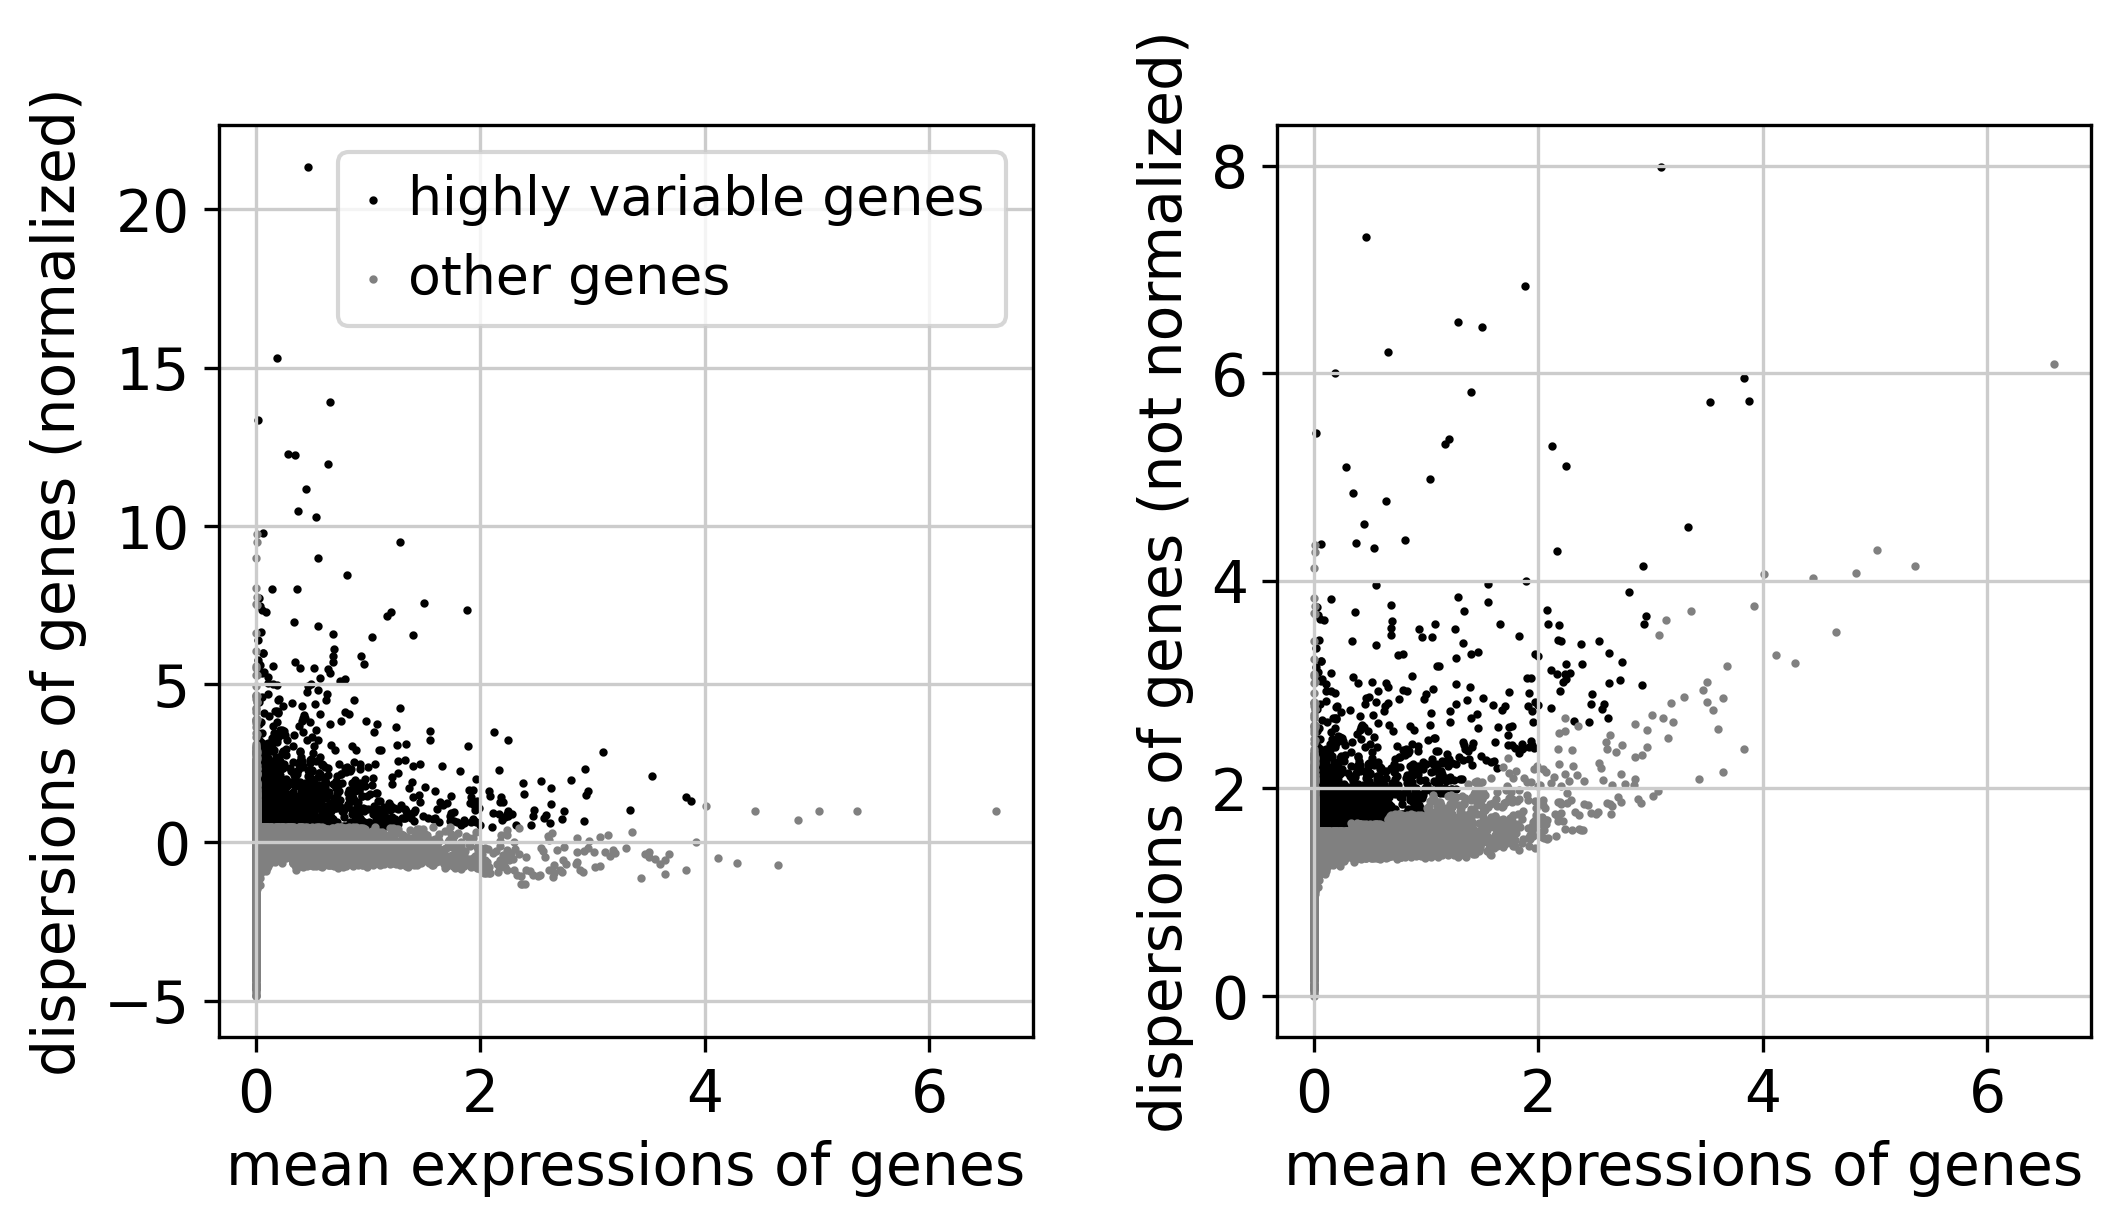

In [ ]:
# Identify highly variable genes
sc.pp.highly_variable_genes(ge, min_mean=0.0125, max_mean=4, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(ge)

In [ ]:
# Filter to only include highly variable
ge = ge[:, ge.var['highly_variable']]

In [ ]:
# Check how many are left - around 1600 left
ge.shape

(53638, 1679)

In [ ]:
# Regress out library size effect
sc.pp.regress_out(ge, keys = ['n_counts'])

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Clip the values with SCALE
sc.pp.scale(ge, max_value=10)

After the normalization, I will perform dimension reduction and cell type classifications on the cells from cancer samples. 

To do this, I first will create a subset of `AnnData` object from `ge` called `ge_cancer`, containing only cells with `ge.obs["cancer"] == True`. 

In [ ]:
ge.obs['cancer']

BMMC_D1T1:AAACCCAAGATGCAGC-1    False
BMMC_D1T1:AAACCCACAAACTCGT-1    False
BMMC_D1T1:AAACCCACAGTGTACT-1    False
BMMC_D1T1:AAACCCATCGCTATTT-1    False
BMMC_D1T1:AAACGAACACCCAATA-1    False
                                ...  
MPAL5R_T2:TTTGGTTTCAGAAATG-1     True
MPAL5R_T2:TTTGGTTTCCTTGCCA-1     True
MPAL5R_T2:TTTGTCAAGGACAGCT-1     True
MPAL5R_T2:TTTGTCACAGATGAGC-1     True
MPAL5R_T2:TTTGTCATCTCGTTTA-1     True
Name: cancer, Length: 53638, dtype: bool

In [ ]:
#============================================================================
# Create another AnnData object called ge_cancer containing only the cells in
# cancer samples from ge
#============================================================================
ge_cancer = ge[ge.obs['cancer'] == True]

In [ ]:
ge_cancer.obs['cancer']

MPAL1_T1:AAAGATGAGCCACGCT-1     True
MPAL1_T1:AAAGATGTCGTGGACC-1     True
MPAL1_T1:AAAGCAAAGAATTGTG-1     True
MPAL1_T1:AAAGTAGAGACACGAC-1     True
MPAL1_T1:AAATGCCCAATTGCTG-1     True
                                ... 
MPAL5R_T2:TTTGGTTTCAGAAATG-1    True
MPAL5R_T2:TTTGGTTTCCTTGCCA-1    True
MPAL5R_T2:TTTGTCAAGGACAGCT-1    True
MPAL5R_T2:TTTGTCACAGATGAGC-1    True
MPAL5R_T2:TTTGTCATCTCGTTTA-1    True
Name: cancer, Length: 18056, dtype: bool

In [ ]:
ge_cancer.shape

(18056, 1679)

Next is dimensionality reduction, visualization, and clustering on the cells from normal samples, using these steps:

1. Perform principle component analysis (PCA) with `svd_solver="arpack"`, and do a `pca_variance_ratio` plot to see what would be a resonable number of principle components.
2. Run neighbor-finding algorithm (`neighbors`) to find neighbors for each cell with arguments `n_neighbors=15`, `n_pcs=20` (20 is my recommend number of PCs, you may consider other numbers based on your observations of `pca_variance_ratio` plot.
3. Visualize the cells with UMAP and color the cells with `leiden` cluster outcome (you'll have to run `leiden` first to get the clusters). Also set `legend_loc="on data"` to label each cluster number.

In [ ]:
ge_cancercopy = ge_cancer

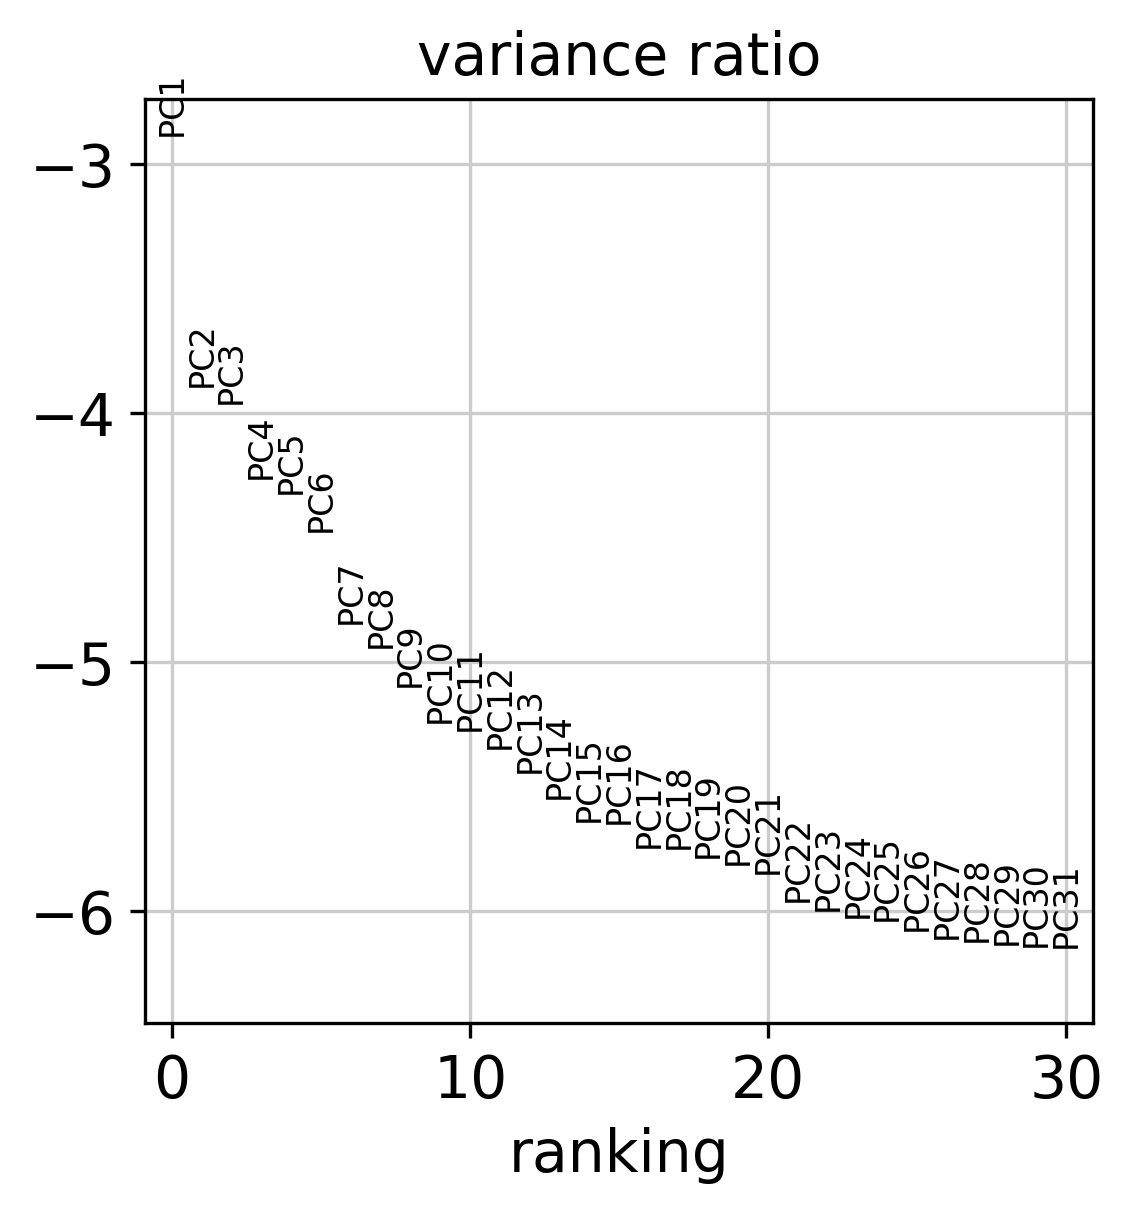

In [ ]:
#=============================================================================
# Perform PCA, neighbors, UMAP, leiden and show UMAP visualization with leiden
# cluster result
#=============================================================================

# Perform the PCA
sc.tl.pca(ge_cancercopy, svd_solver='arpack')
sc.pl.pca_variance_ratio(ge_cancercopy, log=True)

In [ ]:
# Run the neighbors algorithm with n = 15, n_pcs = 20
sc.pp.neighbors(ge_cancercopy, n_neighbors=15, n_pcs=20)

In [ ]:
# UMAP, color 'leiden', legend_doc = 'on data'
# First run leiden to get clusters
sc.tl.leiden(ge_cancercopy)

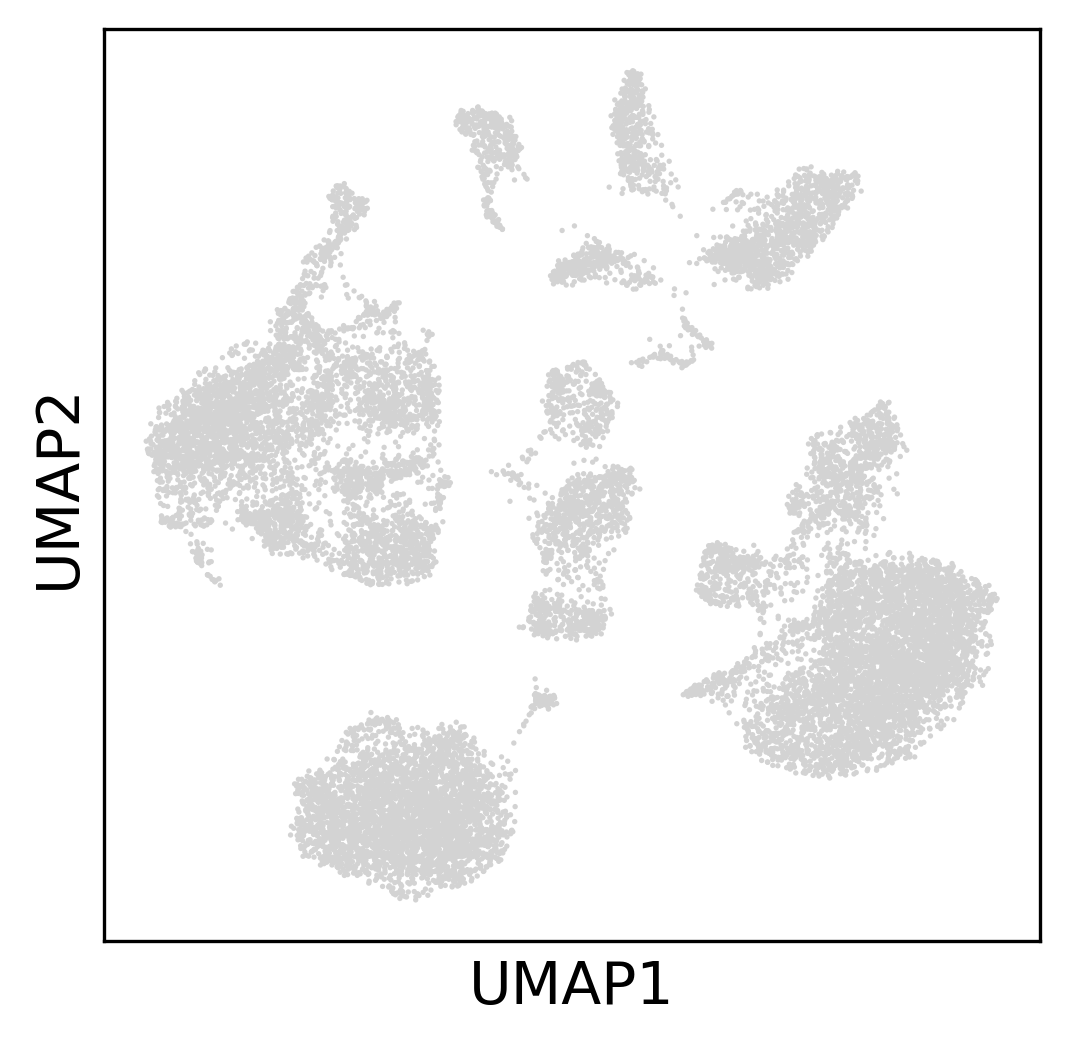

In [ ]:
sc.tl.umap(ge_cancercopy)
sc.settings.set_figure_params(dpi=150)
sc.pl.umap(ge_cancercopy)

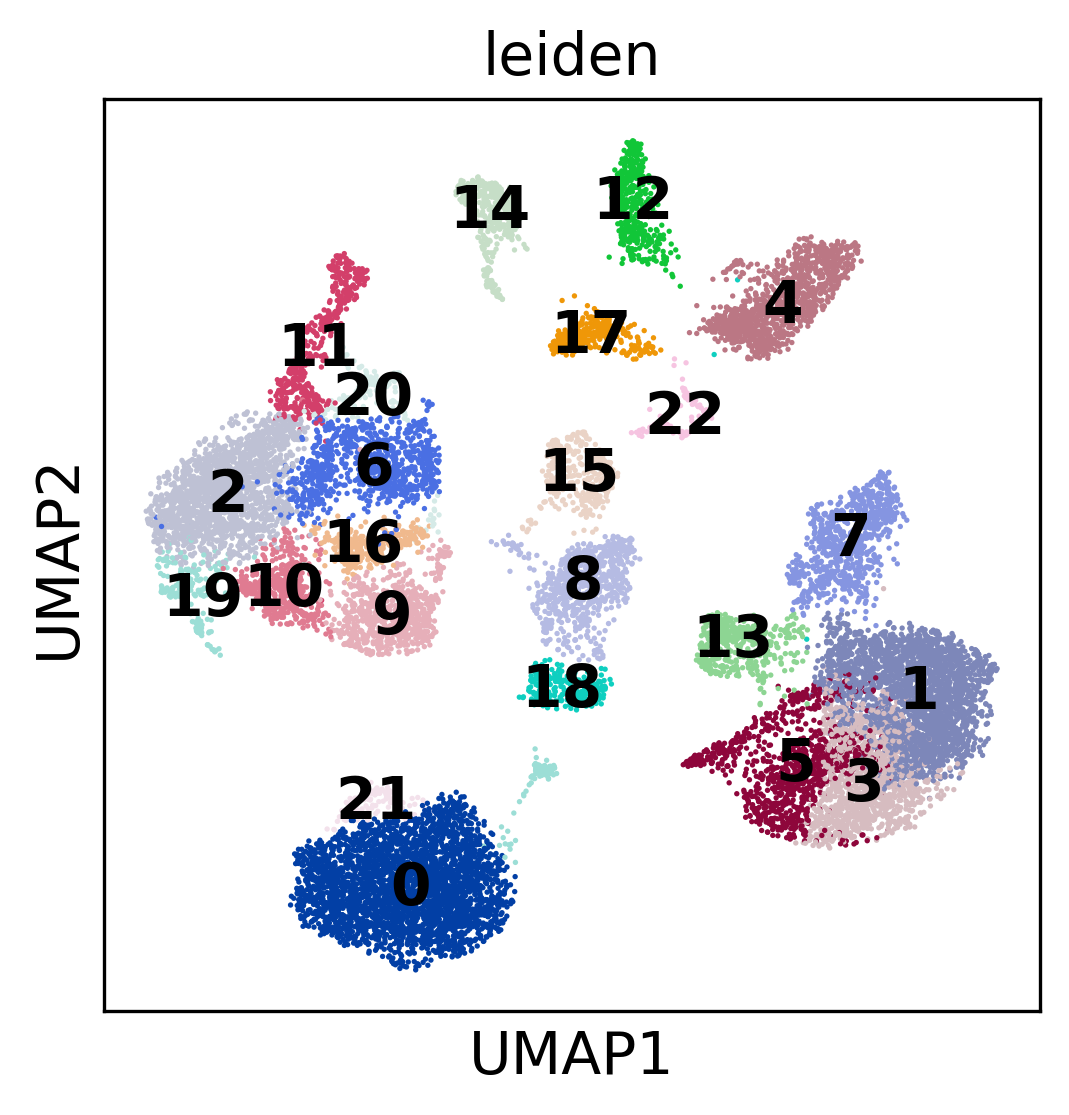

In [ ]:
# Run UMAP
sc.pl.umap(ge_cancercopy, color=['leiden'], legend_loc='on data')

In [ ]:
ge_cancercopy.obs.leiden

MPAL1_T1:AAAGATGAGCCACGCT-1     4
MPAL1_T1:AAAGATGTCGTGGACC-1     4
MPAL1_T1:AAAGCAAAGAATTGTG-1     4
MPAL1_T1:AAAGTAGAGACACGAC-1     4
MPAL1_T1:AAATGCCCAATTGCTG-1     4
                               ..
MPAL5R_T2:TTTGGTTTCAGAAATG-1    9
MPAL5R_T2:TTTGGTTTCCTTGCCA-1    6
MPAL5R_T2:TTTGTCAAGGACAGCT-1    6
MPAL5R_T2:TTTGTCACAGATGAGC-1    6
MPAL5R_T2:TTTGTCATCTCGTTTA-1    6
Name: leiden, Length: 18056, dtype: category
Categories (23, object): ['0', '1', '2', '3', ..., '19', '20', '21', '22']

Here, I will use the protein expression data to label some of the more obvious immune cell types and identify differentially expressed genes.

Load the protein expression data from the `gse139369_scadt` folder. Perform the following data weangling steps:

1. Subset the protein expression `AnnData` object to only `obs` (rows) containing the overlapping cancer scrna cells and scadt cells. 
2. Add suffix `_p` to the var_names to distinguish it from gene names
3. Perform `log1p` transformation on the protein expression values.

In [ ]:
import pandas as pd

sc.tl.rank_genes_groups(ge_cancercopy, 'leiden', method = 't-test')

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [ ]:
pd.DataFrame(ge_cancercopy.uns['rank_genes_groups']['names']).head(25)

0       1       2       3  ...        19      20        21        22
0       KLF6    XIST     HBB    XIST  ...      CD74     HBB   RAPGEF5       HBB
1       CD74  FCER1A   NUCB2    HOPX  ...       HBB  TUBA1B   CLEC10A      HBA1
2    HLA-DRA   ITM2A  SPINK2   CYTL1  ...   HLA-DRA   H2AFZ      ENHO      HBA2
3       KLF2   LTC4S  NAP1L1     GSN  ...      ACY3   HMGB2     PLBD1     ALAS2
4       EGR1    CTSA    SELL    CD34  ...      HBA2    TYMS      CPVL      AHSP
5   HLA-DPB1   CCND2    DNTT  ZBTB16  ...     CXCR4   NUCB2     BASP1  SLC25A37
6       YBX3  TYROBP  GLIPR1   CCND2  ...      TCF4     JUN      RBP7       HBD
7   HLA-DPA1   EGFL7   ITM2C    CTSA  ...     MEF2C   HMGB1     MARCO       CA1
8      ZFAS1   LIMS1    HBA2   ITM2A  ...      IRF8     TK1   LAPTM4B      GYPA
9   HIST1H1D   CYTL1  SUCNR1   GFI1B  ...  HLA-DRB1   STMN1     MPEG1     BLVRB
10     MYADM    TESC   ZFAS1    PIM1  ...   HLA-DMB   MKI67     CD163       HBM
11     ITM2C  ZBTB16    HBA1    CD84  ...       LTB   CKS1B    CD300E      GYPB
12      MCL1    CD84   MGST1  FCER1A  ...    MAP3K8    SELL      LRP1     PRDX2
13      H1FX    AIF1    LST1  GTF3C5  ...    POU2F2    HBA2    CYP1B1       CA2
14    PRSS57  ITGA2B   SPNS3   LIMS1  ...  HLA-DPB1    SMC4       NMU    EIF1AY
15    LGALS1  GTF3C5  LGALS1    PPBP  ...   RAPGEF5    PCNA  SERPINA1      HMBS
16     DUSP1  CDKN2A     ADA    AIF1  ...  HLA-DPA1     AK5      C1QA    COL5A3
17  HIST1H1E  IGFBP7  PIK3R1  ANGPT1  ...    GLIPR1  NUSAP1      BEX1      LCN8
18    IFITM3   GFI1B    FLT3  RAB27B  ...      LY86    TUBB     HMOX1     TCL1B
19   ZFP36L2    HOPX  LRRC28  PDLIM1  ...      RGS1   CLSPN    NECAB1    VSTM2B
20     NPDC1   PTGS1   HMGB1  IGFBP7  ...   CLEC10A   CENPM    KCTD12     EPPK1
21    TPSAB1    HPGD    MEST    CDK6  ...      ENHO    HBA1     LYPD2      RHAG
22  HIST1H1C     GSN    MZB1   EGFL7  ...      CD37   ZWINT       AVP   CACNA1I
23       AES    CD34    LAT2  ITGA2B  ...      RGS2    SMC2      NRGN  ADAMTSL5
24      RGCC   RAB32     AK5   NCAM1  ...      PLD4    MCM7     APOC1     RBM11

[25 rows x 23 columns]

In [ ]:
# First, load the protein expression data from gse_scadt folder
# Read the directory containing barcodes, genes, and matrix.mtx files
g_prot = sc.read_10x_mtx(DATA / "gse139369_scadt")

g_prot.obs_names

Index(['BMMC_D1T1:AAACCCAAGATGCAGC-1', 'BMMC_D1T1:AAACCCACAAACTCGT-1',
       'BMMC_D1T1:AAACCCACAGTGTACT-1', 'BMMC_D1T1:AAACCCATCGCTATTT-1',
       'BMMC_D1T1:AAACGAACACCCAATA-1', 'BMMC_D1T1:AAACGAACAGCAGTCC-1',
       'BMMC_D1T1:AAACGAACATGACGAG-1', 'BMMC_D1T1:AAACGAATCAAGCCAT-1',
       'BMMC_D1T1:AAACGCTAGCCGTAAG-1', 'BMMC_D1T1:AAACGCTAGCTAAACA-1',
       ...
       'MPAL5R_T2:TTTCCTCTCACCGGGT-1', 'MPAL5R_T2:TTTCCTCTCCACGCAG-1',
       'MPAL5R_T2:TTTCCTCTCGGTCCGA-1', 'MPAL5R_T2:TTTGCGCTCAACACGT-1',
       'MPAL5R_T2:TTTGGTTAGGATGGTC-1', 'MPAL5R_T2:TTTGGTTTCAGAAATG-1',
       'MPAL5R_T2:TTTGGTTTCCTTGCCA-1', 'MPAL5R_T2:TTTGTCAAGGACAGCT-1',
       'MPAL5R_T2:TTTGTCACAGATGAGC-1', 'MPAL5R_T2:TTTGTCATCTCGTTTA-1'],
      dtype='object', length=58771)

In [ ]:
g_prot.var_names.shape

(21,)

In [ ]:
#============================================================================
# Read the protein expression data, subsetting it to overlapping samples, and
# log1p transform it
#============================================================================
overlap_cells = set(g_prot.obs_names) & set(ge_cancercopy.obs_names)

g_prot = g_prot[g_prot.obs_names.isin(overlap_cells)]
ge_cancercopy = ge_cancercopy[ge_cancercopy.obs_names.isin(overlap_cells)]

# log1p transform the data
g_prot.X = np.log1p(g_prot.X)
g_prot.var_names = [x + "_p" for x in g_prot.var_names]
g_prot.var_names



Index(['CD10_p', 'CD123_p', 'CD14_p', 'CD19_p', 'CD3_p', 'CD33_p', 'CD34_p',
       'CD38_p', 'CD4_p', 'CD45RA_p', 'CD7_p', 'CD8A_p', 'CD90_p', 'CD15_p',
       'CD16_p', 'CD56_p', 'CD25_p', 'CD45RO_p', 'PD-1_p', 'TIGIT_p',
       'CD127_p'],
      dtype='object')

In [ ]:
g_prot.var_names.shape

(21,)

In [ ]:
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

Now similar to what was done in lecture, I will merge the protein expression values of the following proteins to `ge_cancer.obs` data frame in order to investigate the protein expression values of each cluster from UMAP.

Since the `X` of the AnnData object is a sparse matrix now, to construct it into a DataFrame, I have to first convert it to dense matrix with `adt.X.toarray()` where the `adt` is the object of the protein expression AnnData.

In [ ]:
g_prot.X

<17850x21 sparse matrix of type '<class 'numpy.float32'>'
	with 153971 stored elements in Compressed Sparse Row format>

In [ ]:
# Convert g_prot.X to a dense matrix
g_prot.X = g_prot.X.toarray()

In [ ]:
g_prot.X

array([[2.8903718, 5.8435445, 2.8332133, ..., 0.       , 0.       ,
        0.       ],
       [1.3862944, 1.9459102, 2.7080503, ..., 0.       , 0.       ,
        0.       ],
       [1.9459102, 5.0238805, 3.5553482, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 3.6888795, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.2580965, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.6888795, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
g_prot.var_names

Index(['CD10_p', 'CD123_p', 'CD14_p', 'CD19_p', 'CD3_p', 'CD33_p', 'CD34_p',
       'CD38_p', 'CD4_p', 'CD45RA_p', 'CD7_p', 'CD8A_p', 'CD90_p', 'CD15_p',
       'CD16_p', 'CD56_p', 'CD25_p', 'CD45RO_p', 'PD-1_p', 'TIGIT_p',
       'CD127_p'],
      dtype='object')

In [ ]:
#==================================================================
# Merge the protein expression values to the ge_cancer.obs data frame
#==================================================================

# Construct g_prot.X to a dataframe
g_prot_mat = pd.DataFrame(g_prot.X, index=g_prot.obs.index.values, columns=g_prot.var.index.values)

In [ ]:
g_prot_mat

CD10_p   CD123_p  ...  TIGIT_p  CD127_p
MPAL1_T1:AAGGCAGCAGTTCATG-1   2.890372  5.843544  ...      0.0      0.0
MPAL1_T1:CGAGCACCATGGTCTA-1   1.386294  1.945910  ...      0.0      0.0
MPAL1_T2:AAACCTGAGAAACGAG-1   1.945910  5.023880  ...      0.0      0.0
MPAL1_T2:AAACCTGAGCAGACTG-1   1.609438  5.666427  ...      0.0      0.0
MPAL1_T2:AAACCTGAGTGGAGTC-1   1.791759  2.772589  ...      0.0      0.0
...                                ...       ...  ...      ...      ...
MPAL5R_T2:TTTGGTTTCAGAAATG-1  0.000000  0.000000  ...      0.0      0.0
MPAL5R_T2:TTTGGTTTCCTTGCCA-1  0.000000  0.000000  ...      0.0      0.0
MPAL5R_T2:TTTGTCAAGGACAGCT-1  0.000000  0.000000  ...      0.0      0.0
MPAL5R_T2:TTTGTCACAGATGAGC-1  0.000000  0.000000  ...      0.0      0.0
MPAL5R_T2:TTTGTCATCTCGTTTA-1  0.000000  0.000000  ...      0.0      0.0

[17850 rows x 21 columns]

In [ ]:
ge_test = ge_cancercopy

In [ ]:
# Merge with ge_cancer.obs
ge_test.obs = ge_test.obs.merge(g_prot_mat, how="left", left_index=True, right_index=True)

In [ ]:
ge_test.obs.head()

sample_id  cancer  ...  TIGIT_p CD127_p
MPAL1_T1:AAGGCAGCAGTTCATG-1  MPAL1_T1    True  ...      0.0     0.0
MPAL1_T1:CGAGCACCATGGTCTA-1  MPAL1_T1    True  ...      0.0     0.0
MPAL1_T2:AAACCTGAGAAACGAG-1  MPAL1_T2    True  ...      0.0     0.0
MPAL1_T2:AAACCTGAGCAGACTG-1  MPAL1_T2    True  ...      0.0     0.0
MPAL1_T2:AAACCTGAGTGGAGTC-1  MPAL1_T2    True  ...      0.0     0.0

[5 rows x 25 columns]

Finally, to label the cell type of the clusters, let's check the expression levels of the following proteins:

* `CD3_p`: Lymphocytes
* `CD8A_p`: CD8+ T cells
* `CD4_p`: CD4+ T cells
* `CD16_p`: NK cells
* `CD19_p`: B cells
* `CD14_p`: Monocytes
* `PD-1_p`: PD-1 expression cells
* `CD123_p`: A marker gene for leukemia
* `CD10_p`: Another gene for leukemia

The UMAP will be colored with the expression levels of the following proteins.


In [ ]:
cluster_names = [
      "Leukemia gene",  # CD10_p
      "Leukemia marker gene", #CD123_p
      "Monocytes",    # CD14_p
      "B-cells",      # CD19_p
      "Lymphocytes",  # CD3_p
      "CD33_p",
      "CD34_p",
      "CD38_p",
      "CD4+ T",       # CD4_p
      "CD45RA_p",
      "CD7_p",
      "CD8+ T",       # CD8A_p
      "CD90_p",
      "CD15_p",
      "NK",           # CD16_p
      "CD56_p",
      "CD25_p",
      "CD45RO_p",
      "PD-1 expression",  # PD-1_p
      "TIGIT_p",
      "CD127_p",
      "21",
      "22",
]

In [ ]:
PROTEIN_GENE_PAIR = [("CD3_p", "CD3G"), ("CD4_p", "CD4"), ("CD8A_p", "CD8A"),
                     ("CD16_p", "FCGR3A"), ("CD19_p", "CD19"),
                     ("CD14_p", "CD14"), ("PD-1_p", "PDCD1"),
                     ("CD10_p", "MME"), ("CD123_p", "IL3RA")]

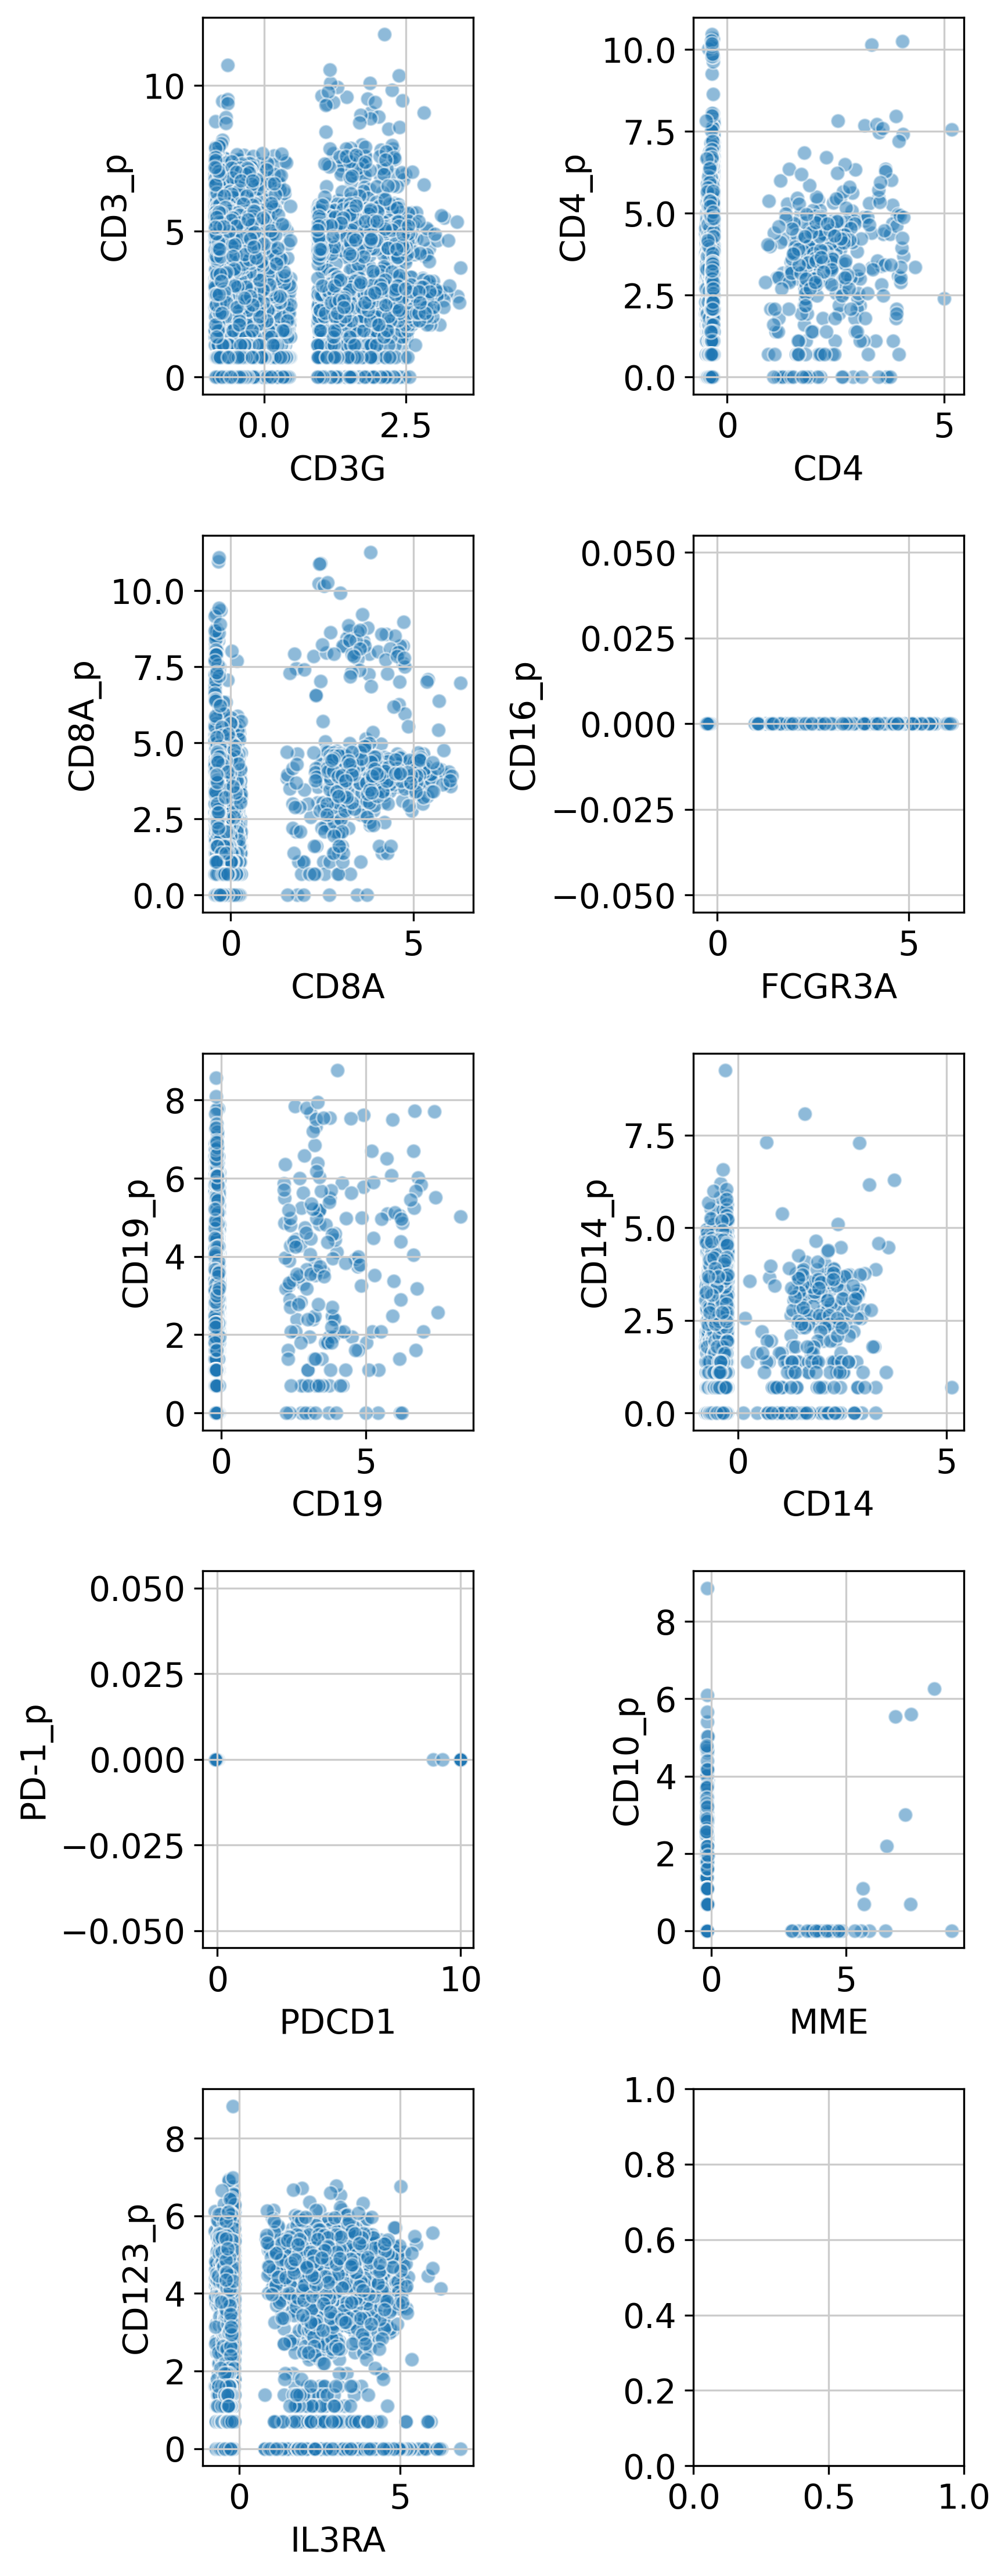

In [ ]:
fig, axarr = plt.subplots(5, 2, dpi=150, figsize=(6, 15))
for i, (p, g) in enumerate(PROTEIN_GENE_PAIR):
    rowidx = i // 2
    colidx = i % 2
    ax = axarr[rowidx, colidx]
    plotdata = pd.concat([g_prot[:, p].to_df(), ge_test[:, g].to_df()], axis=1, sort=True)
    sns.scatterplot(x=g, y=p, data=plotdata, alpha=0.5, ax=ax)

plt.tight_layout()

In [ ]:
ge_cancercopy.obs.leiden

MPAL1_T1:AAGGCAGCAGTTCATG-1      4
MPAL1_T1:CGAGCACCATGGTCTA-1      8
MPAL1_T2:AAACCTGAGAAACGAG-1     12
MPAL1_T2:AAACCTGAGCAGACTG-1     12
MPAL1_T2:AAACCTGAGTGGAGTC-1     18
                                ..
MPAL5R_T2:TTTGGTTTCAGAAATG-1     9
MPAL5R_T2:TTTGGTTTCCTTGCCA-1     6
MPAL5R_T2:TTTGTCAAGGACAGCT-1     6
MPAL5R_T2:TTTGTCACAGATGAGC-1     6
MPAL5R_T2:TTTGTCATCTCGTTTA-1     6
Name: leiden, Length: 17850, dtype: category
Categories (23, object): ['0', '1', '2', '3', ..., '19', '20', '21', '22']

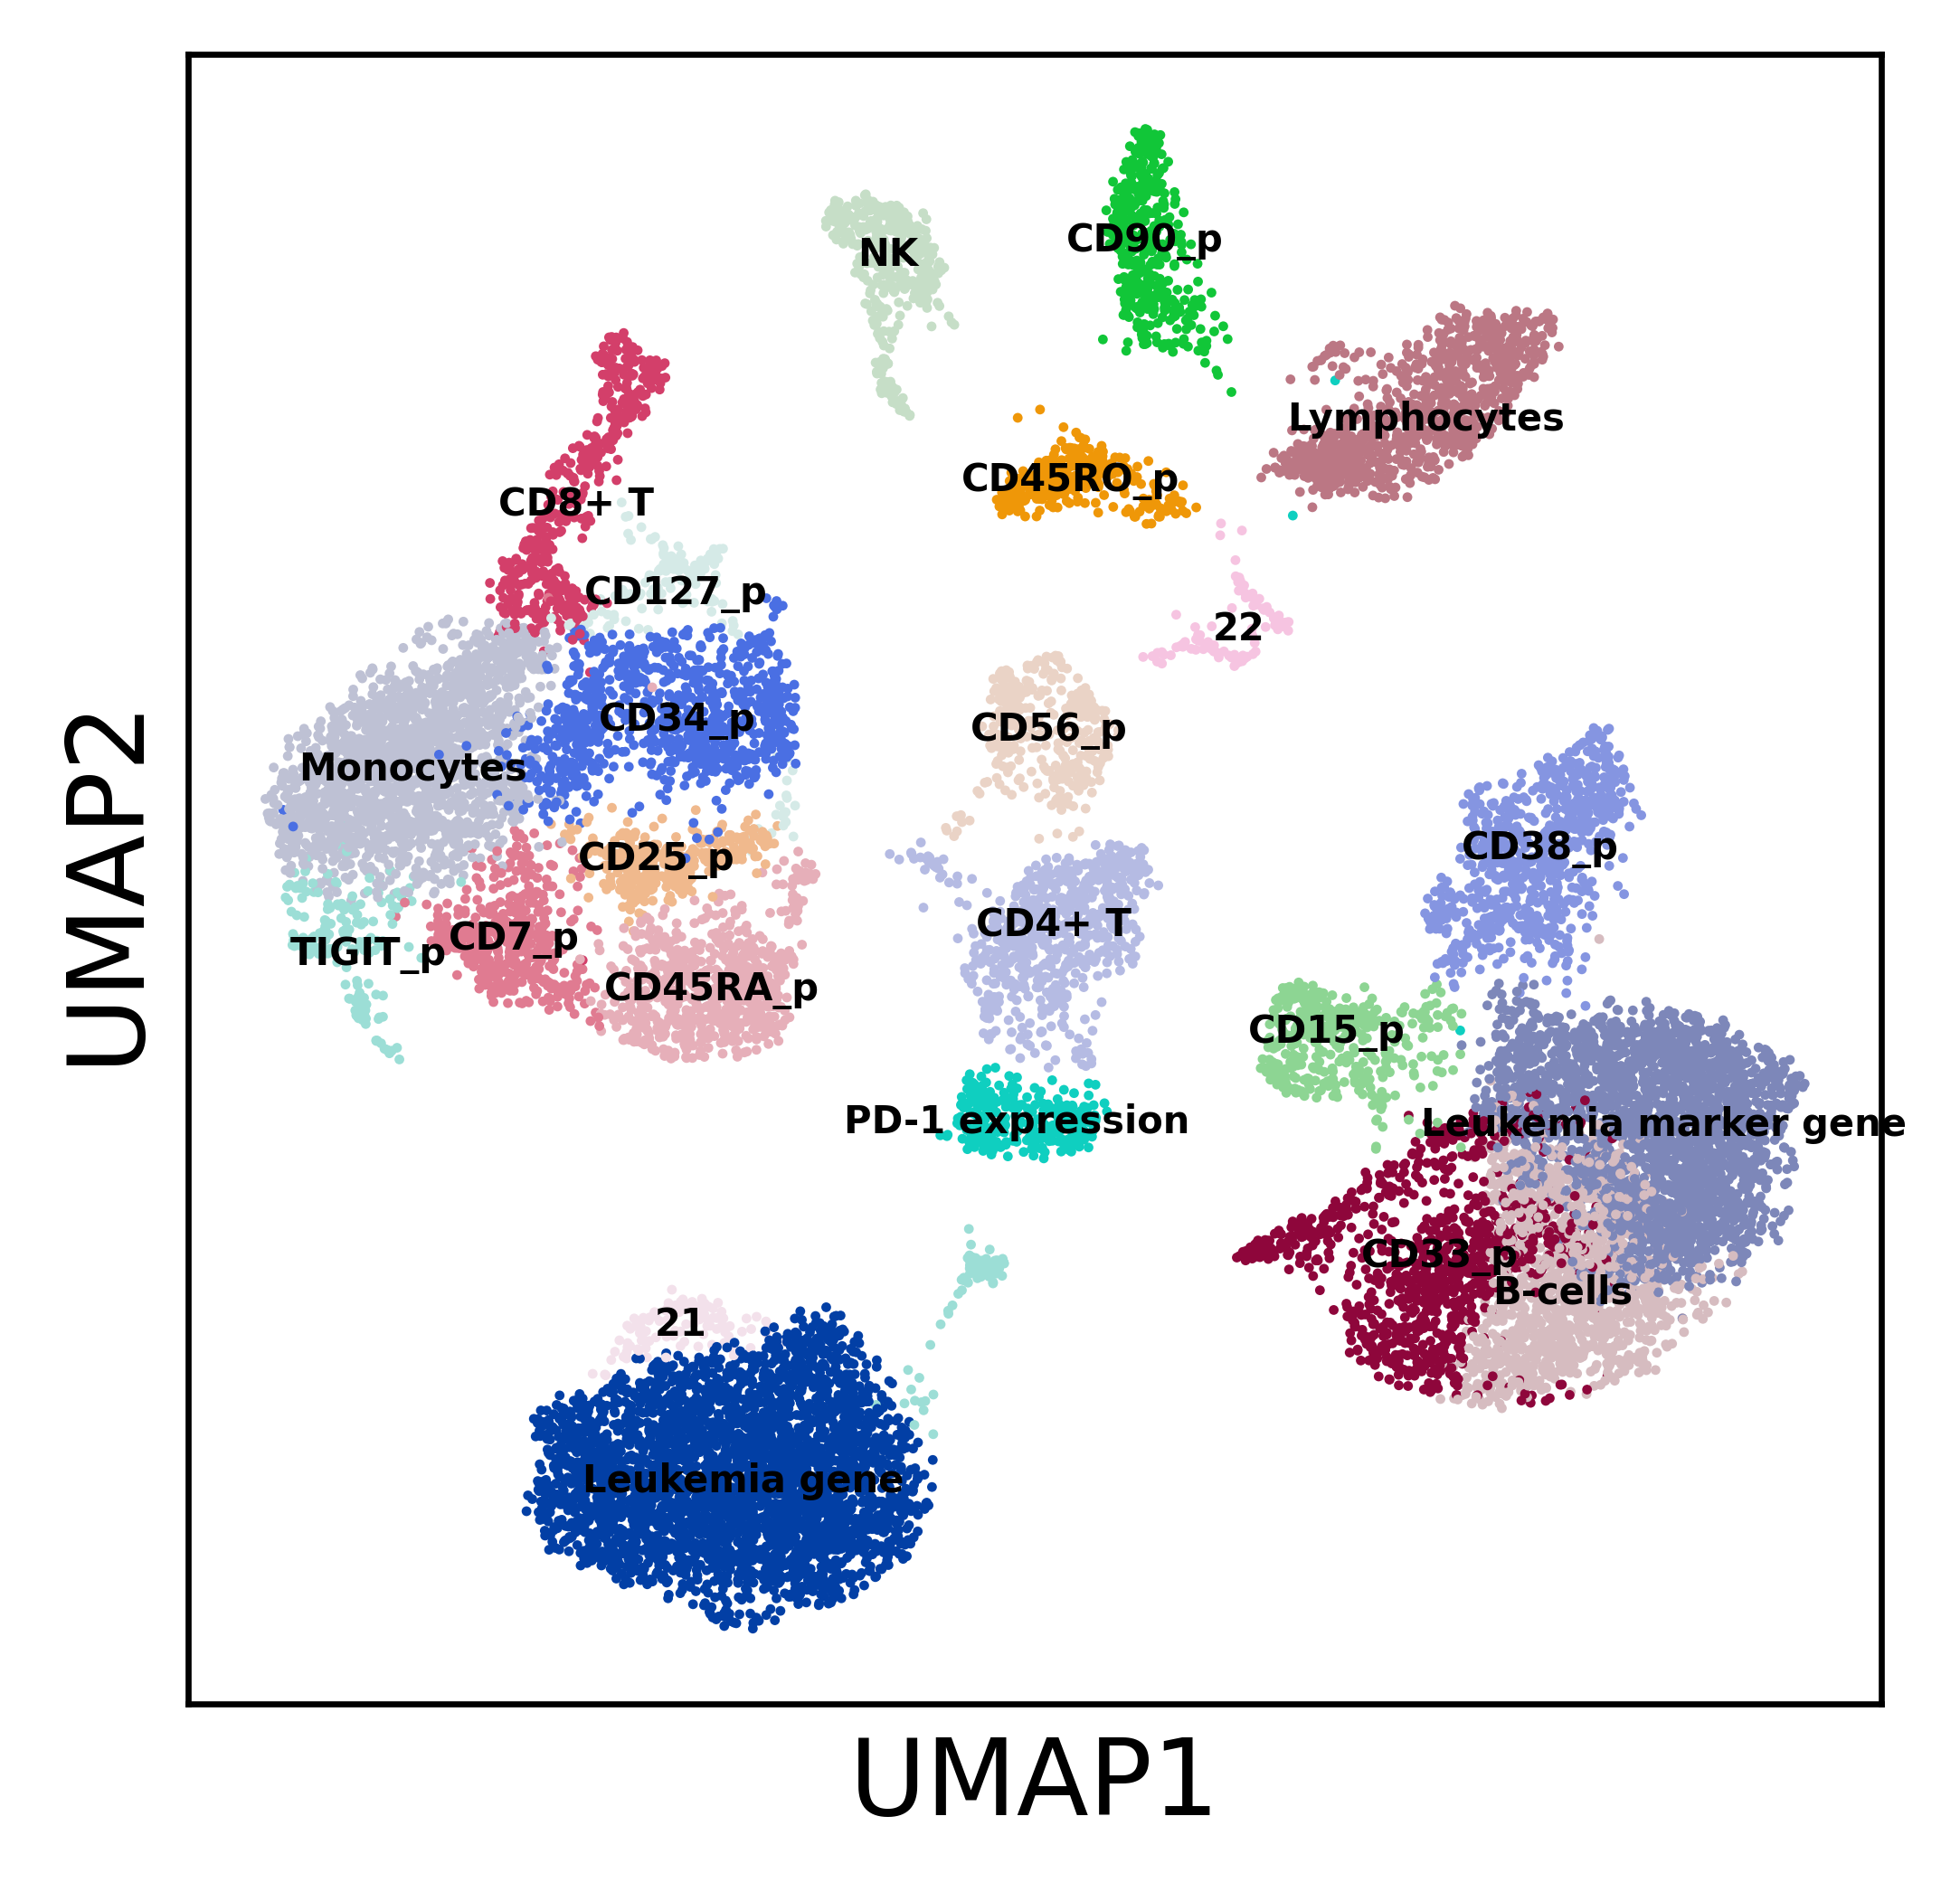

In [ ]:
#==================================================================
# Color the UMAP with the above mentioned protein expression levels
#==================================================================

sc.settings.set_figure_params(dpi=300)
ge_test.rename_categories('leiden', cluster_names)
sc.pl.umap(ge_test, color='leiden', legend_loc='on data', title='', legend_fontsize=5)

The mapping of the leiden clusters to the corresponding protein markers with names is shown on the UMAP above and the RNAseq-based annotation below.

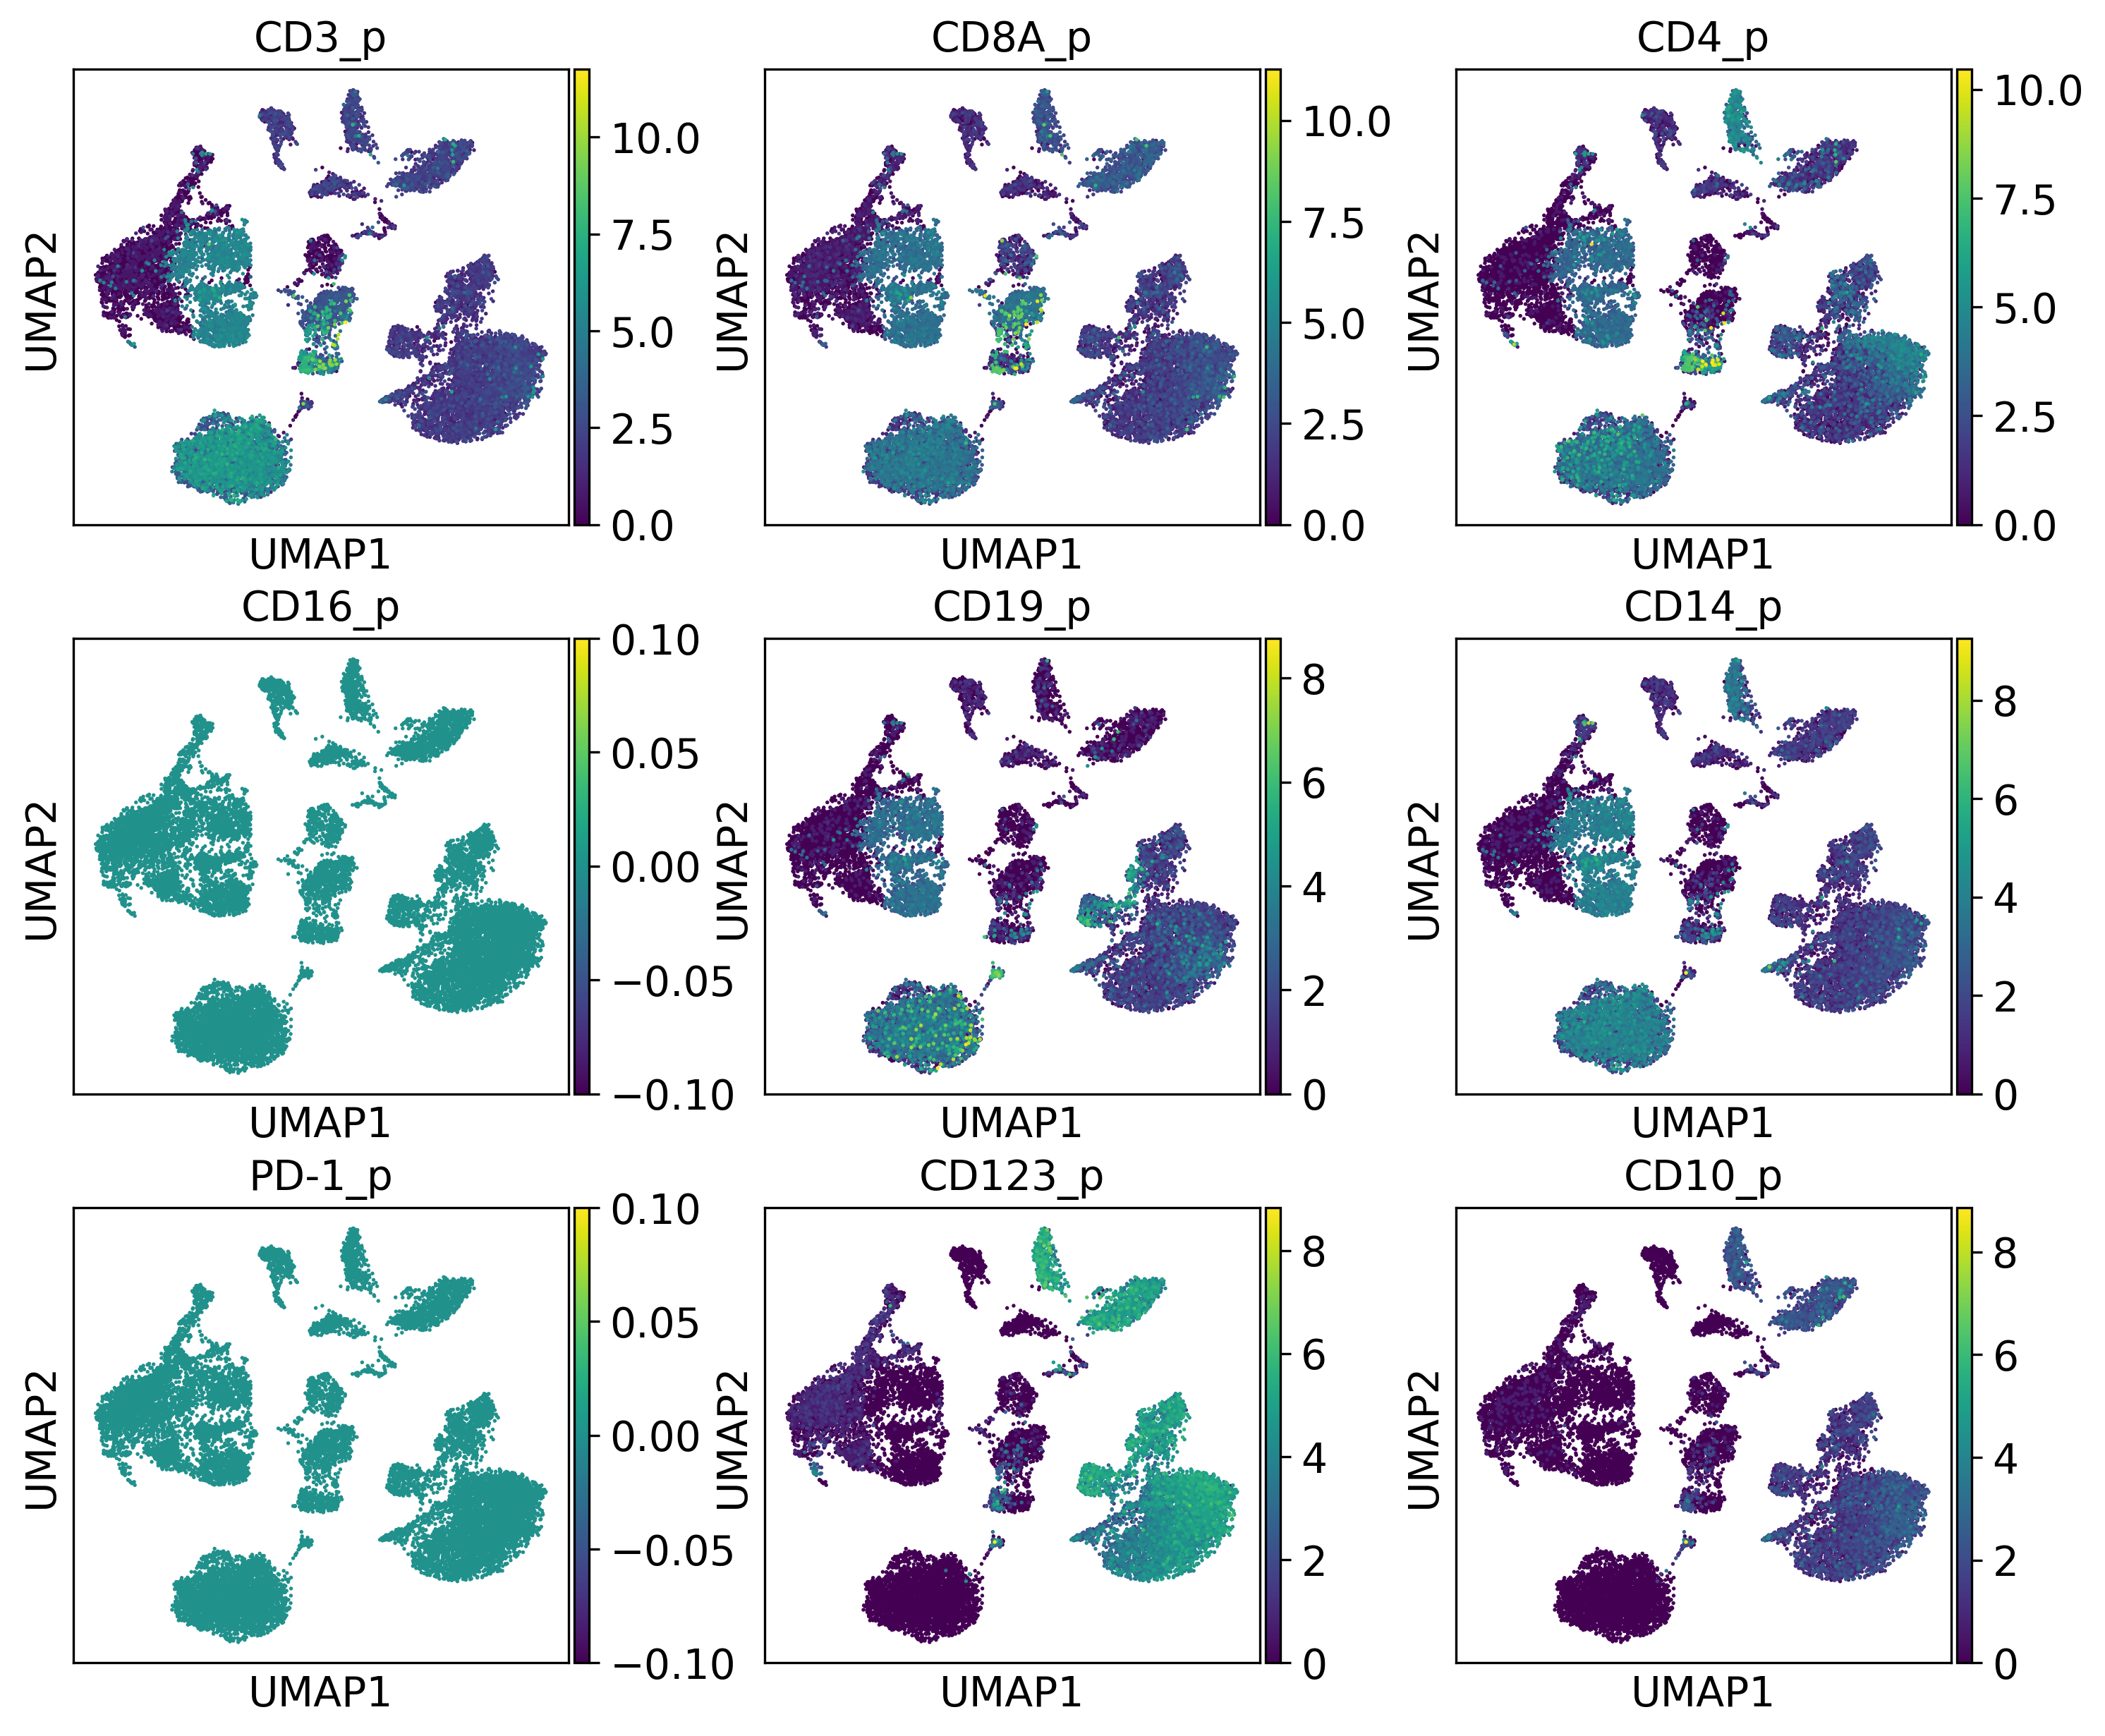

In [ ]:
sc.settings.set_figure_params(dpi=150, figsize=(3,3))
sc.pl.umap(ge_test, color=['CD3_p', 'CD8A_p', 'CD4_p', 'CD16_p', 'CD19_p', 'CD14_p', 'PD-1_p', 'CD123_p', 'CD10_p'],
           legend_loc='on data', ncols=3)

Based on the above umaps using RNAseq-based annotation, we can see that depsite there existing a PD-1 cluster, there was no PD-1 expression in the T cells. Based on the protein feature and mRNA expression correlation analysis, it was also apparent that there was very little PD-1 expression observed.

## Identify malignant program in MPAL samples

Prompt: Now let's extract the CD10+ and CD123+ clusters in the previous analysis. We'll assume they are the malignant leukemia cells and perform further clustering analysis on them.

To start, I will create another subset of the `ge_cancer` object with cells coming from the CD10+ and CD123+ clusters. It will be called `ge_mal` for malignant.

In [ ]:
ge123 = ge_test[ge_test.obs['leiden'] == 'Leukemia marker gene', :]
ge123.shape

(2413, 1679)

In [ ]:
geCD10 = ge_test[ge_test.obs['leiden'] == 'Leukemia gene', :]
geCD10.shape

(3328, 1679)

In [ ]:
#===========================================================================
# Subset ge_cancer by extracting only cells coming from the CD10+ and CD123+
# clusters. Name the subset AnnData ge_mal
#===========================================================================

# ge_mal = ((ge_test[:, "MME"].X > 0) | (ge_test[:, "IL3RA"].X > 0))

# ge_mal.sum()

idx = ge_test[(ge_test.obs['leiden'] == 'Leukemia gene') | (ge_test.obs['leiden'] == 'Leukemia marker gene'), :]

idx.shape

(5741, 1679)

In [ ]:
# I did not observe 7000 cells like mentioned in the spec...

# However, when I tried to use the method from 11-30 lecture for finidng all the cells with specific genes, 
# in this case MME and IL3RA, I only got around 3000.

# Therefore, I tried to use this method instead for finidng the total number of cells within those two clusters
# The number of clusters however were still not equal to the amount stated here.

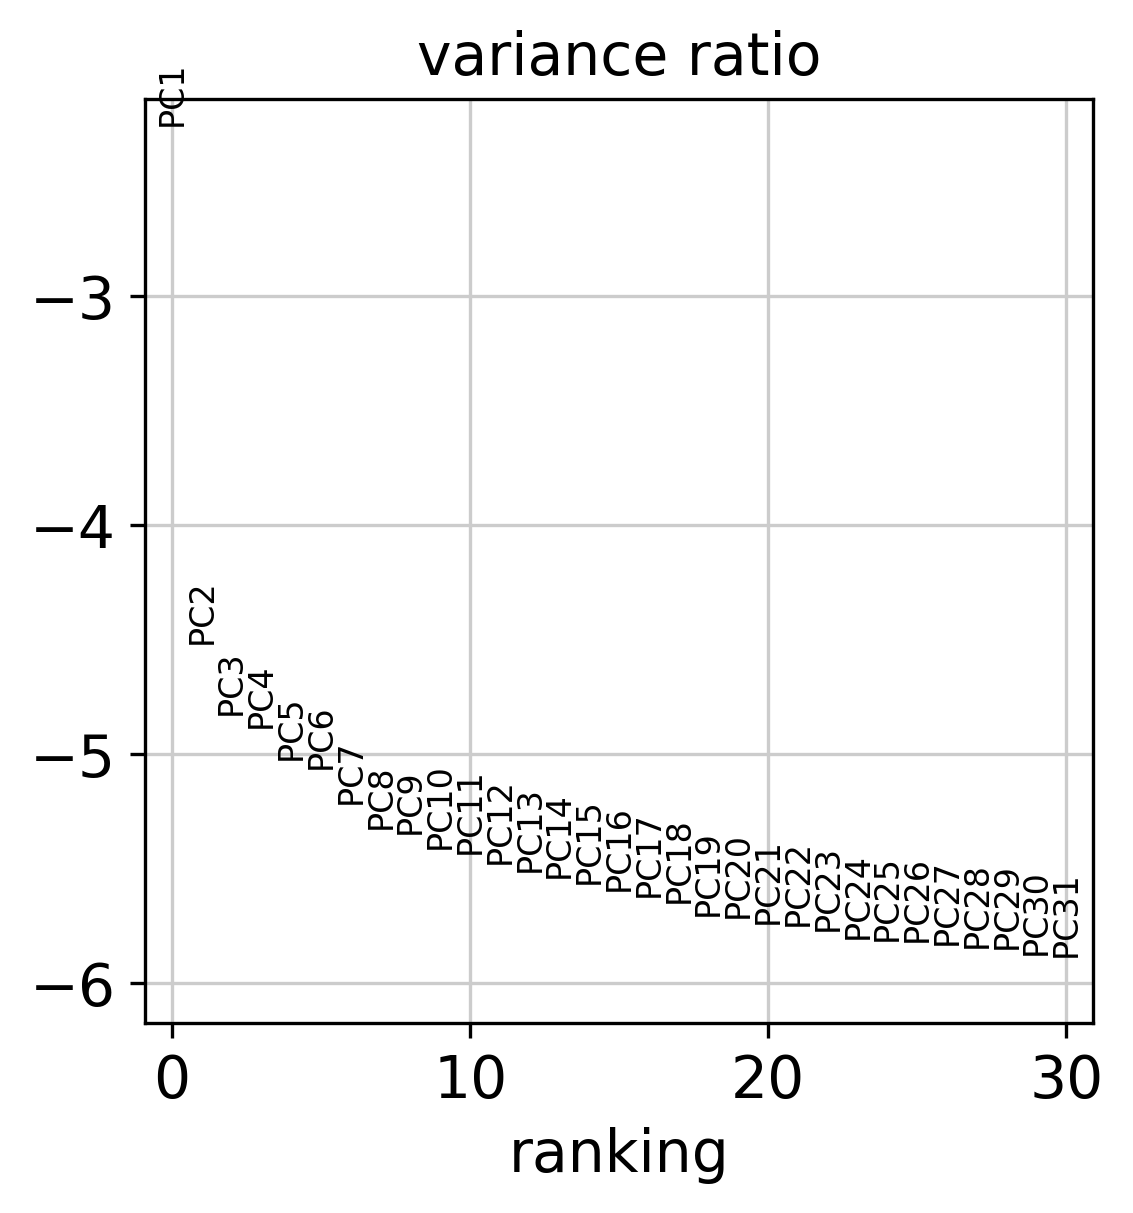

In [ ]:
#===============================================================
# Perform PCA, neighbor finding, and leiden on the ge_mal object
#===============================================================

sc.tl.pca(idx, svd_solver='arpack')
sc.pl.pca_variance_ratio(idx, log=True)

# sc.tl.pca(mals, svd_solver='arpack')
# sc.pl.pca_variance_ratio(mals, log=True)

In [ ]:
sc.pp.neighbors(idx, n_neighbors=15, n_pcs=20)

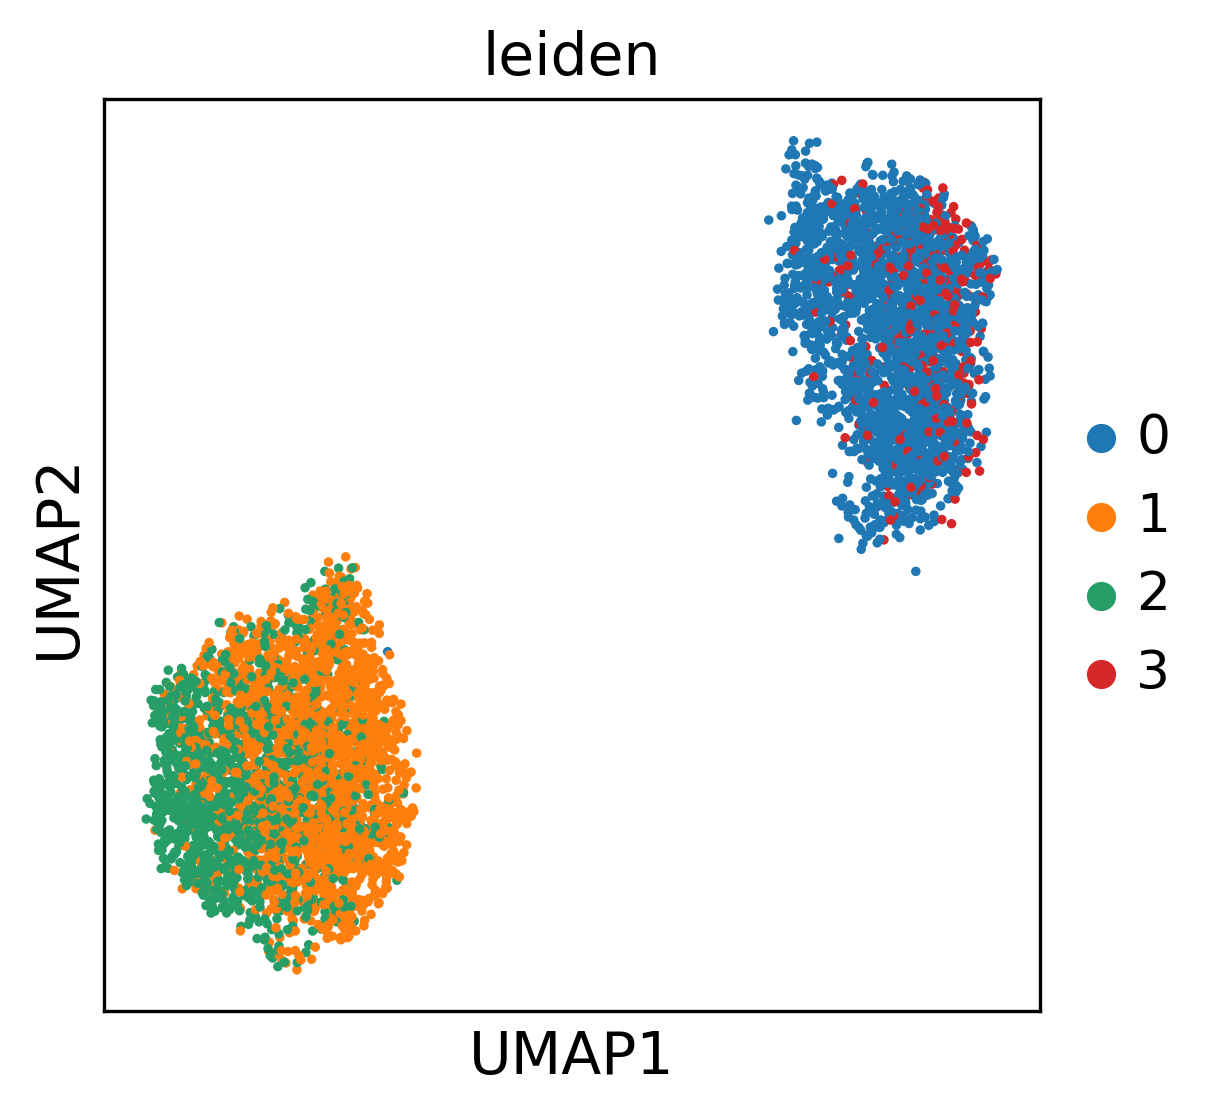

In [ ]:
sc.tl.leiden(idx, resolution=0.1)
sc.settings.set_figure_params(dpi=150)
sc.pl.umap(idx, color=["leiden"])

In [ ]:
# Extract the top 50 differentially expressed genes

sc.tl.rank_genes_groups(idx, 'leiden', method='t-test')

mals_cluster_genes = pd.DataFrame(idx.uns['rank_genes_groups']['names'])
mals_cluster_genes.head(50)

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


0           1           2        3
0      XIST        KLF6        KLF6     SPP1
1    FCER1A        CD74      LGALS1   FCER1A
2    ZBTB16     HLA-DRA        CD74     XIST
3      CTSA       ITM2C        KLF2     CTSA
4     LTC4S    HLA-DPB1        EGR1   ZBTB16
5     CYTL1    HLA-DPA1     HLA-DRA    CYTL1
6    ITGA2B      LGALS1       ITM2C    LTC4S
7     CCND2        EGR1        YBX3     LST1
8    GTF3C5      IFITM3      PRSS57    CCND2
9      TESC       DUSP1      MAMDC2     CD84
10     LST1    HIST1H1D        CD99     TESC
11     CD84        YBX3    HLA-DPB1   TYROBP
12   CDKN2A       MGST1       CRIP1    ITM2A
13    GFI1B      PRSS57        MCL1    LIMS1
14    ITM2A        KLF2         AES   CDKN2A
15  CLEC11A       NUCB2        LMNA    EGFL7
16    LIMS1        H1FX       MYADM   ITGA2B
17    PTGS1        FLT3    HLA-DPA1    PTGS1
18     PIM1     ZFP36L2       DUSP1  CLEC11A
19     CDK6         AES        H1FX    GFI1B
20     HPGD    HLA-DRB1       MGST1   GTF3C5
21   TYROBP         ADA     ANKRD28     HPGD
22    PDZD8      BCL11A    HIST1H1E    CXCL2
23     PPBP        MCL1    HIST1H1D    HPGDS
24      GSN        H1F0      IFITM3      GSN
25     AIF1    HIST1H1E     ZFP36L2     AIF1
26  ZFP36L1       ZFAS1     S100A10     CDK6
27  ZNF385D       PRDX2        RGCC     CD34
28    EGFL7    HIST1H1C         JUN  ZFP36L1
29  GOLGA8A       NPDC1      TPSAB1     PPBP
30     CD34        DNTT        JUND     PIM1
31     GMPR       NEGR1      THSD7A    STAB1
32     CD52     ANKRD28       ANXA2    CXCL3
33   CDKN2C       MYADM      PTPN14     GMPR
34     PLEK         JUN       ZFAS1    RAB32
35    RAB32     HLA-DMA         ADA     CST3
36    HPGDS  HIST2H2AA3        FOSB    PDZD8
37    HEMGN         AK5       NUCB2     PLEK
38    MAST4        TCF4  HIST2H2AA3     CCL5
39    CASP3        FOSB    HIST1H1C   CDKN2C
40     PSAP     TSC22D1       ZFP36    MAST4
41      CD2       SPNS3        FLT3     PSAP
42    IFRD1       BCL7A       PRDX2      CD2
43  TNFRSF4       DDX3Y        H1F0   IGFBP7
44    CXCL2        SELL        EGR3  ZNF385D
45    ISG15       DUSP6       NPDC1    CASP3
46    MMRN1       SPON2       HOXA9  S100A11
47    STAB1        RGCC    HLA-DRB1     SELP
48     CCL5       GNA15       CRIP2    IFRD1
49     CTSW        CPA3       DDX3Y   RAB27B

In [ ]:
idx.rename_categories('leiden', ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

In [ ]:
data = idx.obs.copy()
# data = mals.obs.copy()

In [ ]:
data['leiden'] = data.leiden.astype(str)
data.head(10)

sample_id  cancer  ...  TIGIT_p CD127_p
MPAL1_T2:GATCAGTTCAAGGTAA-1  MPAL1_T2    True  ...      0.0     0.0
MPAL1_T2:GGCTCGAAGGGATACC-1  MPAL1_T2    True  ...      0.0     0.0
MPAL1_T2:TCGGTAAAGGCATTGG-1  MPAL1_T2    True  ...      0.0     0.0
MPAL2_T1:AAACCTGAGCCCTAAT-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGAGGAATCGC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGAGTCTCGGC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGCACAGCGTC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGGTCAGAAGC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACGGGGTAATAGCA-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACGGGGTATATCCG-1  MPAL2_T1    True  ...      0.0     0.0

[10 rows x 25 columns]

In [ ]:
# My answer: how many cells from each cluster belong to each sample_id, 2.1

cluster_pct = data.groupby(
    ['leiden', 'sample_id'],
).size().reset_index().rename(columns={0: "cells"})

cluster_pct.head(25)

leiden sample_id  cells
0       0  MPAL1_T2      1
1       0  MPAL2_T1   2082
2       0  MPAL4_T1      0
3       0  MPAL4_T2      0
4       0  MPAL5_T1      1
5       1  MPAL1_T2      2
6       1  MPAL2_T1      0
7       1  MPAL4_T1    853
8       1  MPAL4_T2   1121
9       1  MPAL5_T1      3
10      2  MPAL1_T2      0
11      2  MPAL2_T1      0
12      2  MPAL4_T1    624
13      2  MPAL4_T2    724
14      2  MPAL5_T1      0
15      3  MPAL1_T2      0
16      3  MPAL2_T1    330
17      3  MPAL4_T1      0
18      3  MPAL4_T2      0
19      3  MPAL5_T1      0

In [ ]:
# Observing a possible correlation between the source of the cell and the cluster ID:
t = data[data['sample_id'] == 'MPAL2_T1']
t.head()

sample_id  cancer  ...  TIGIT_p CD127_p
MPAL2_T1:AAACCTGAGCCCTAAT-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGAGGAATCGC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGAGTCTCGGC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGCACAGCGTC-1  MPAL2_T1    True  ...      0.0     0.0
MPAL2_T1:AAACCTGGTCAGAAGC-1  MPAL2_T1    True  ...      0.0     0.0

[5 rows x 25 columns]

In [ ]:
v = data[data['sample_id'] == 'MPAL4_T2']
v.head()

sample_id  cancer  ...  TIGIT_p CD127_p
MPAL4_T2:AAACCTGAGAATAGGG-1  MPAL4_T2    True  ...      0.0     0.0
MPAL4_T2:AAACCTGAGACGCTTT-1  MPAL4_T2    True  ...      0.0     0.0
MPAL4_T2:AAACCTGAGGCCCGTT-1  MPAL4_T2    True  ...      0.0     0.0
MPAL4_T2:AAACCTGAGGGTTTCT-1  MPAL4_T2    True  ...      0.0     0.0
MPAL4_T2:AAACCTGTCTCGCTTG-1  MPAL4_T2    True  ...      0.0     0.0

[5 rows x 25 columns]

Based on the UMAP as well as the dataframe from above, it seems that MPAL4_T1 and MPAL4_T2 are more concentrated within Clusters 2 and 3, and Cluster 1 is where MPAL2_T1 seems to concentrate greatly in. However, I did notice that sample IDs of MPAL1 and MPAL5 did not exhibit many samples within these two at all. 

Upon looking at the sequences involved in some of the samples in MPAL2 and MPAL4, it appears that their sequences are very similar, much more similar than MPAL1, MAP3 or MPAL5; perhaps this might be a reason why the sources of cells from these sample IDs and the cluster IDs for these two sample_IDs matched very closely.

In [ ]:
# Comparison of the top 50 genes extracted from malignant clusters to observe possible overlapping between top 50 genes and MPAL genes in the up-regulated gene set noted in the author's paper. 

MPAL = ['IL1RAP', 'CD3D', 'TCF7', 'CD69', 'ATF3', 'CLEC11A',
        'PTGER4', 'RUNX1', 'ICAM4', 'TCF7', 'TSPAN7', 'CCL3', 'KLF6']

AML = ['STAT5A', 'IL2RA', 'NR2F6', 'ZBTB7A', 'HLA-DRB5', 'HOXA9', 'CEBPA', 'HLX',
       'MYC', 'LGALS3', 'IL1B', 'HOXA10']

Cons = ['CDKN2A', 'CD96', 'CCNA1', 'NFE2', 'FLT3', 'CCND3', 'IL3RA', 'HLA-A', 'IFTI2', 'IFTI3',
        'RASGRP3', 'DUSP6', 'IRF9', 'CASP3', 'TNF', 'TNFSF4']

pattern = '|'.join(MPAL)
pattern2 = '|'.join(AML)
pattern3 = '|'.join(Cons)

top50 = mals_cluster_genes.head(50)

MPAL_1 = top50['0'].str.contains(pattern).sum()
MPAL_2 = top50['1'].str.contains(pattern).sum()
MPAL_3 = top50['2'].str.contains(pattern).sum()
MPAL_4 = top50['3'].str.contains(pattern).sum()

AML_1 = top50['0'].str.contains(pattern2).sum()
AML_2 = top50['1'].str.contains(pattern2).sum()
AML_3 = top50['2'].str.contains(pattern2).sum()
AML_4 = top50['3'].str.contains(pattern2).sum()


Cons1 = top50['0'].str.contains(pattern3).sum()
Cons2 = top50['1'].str.contains(pattern3).sum()
Cons3 = top50['2'].str.contains(pattern3).sum()
Cons4 = top50['3'].str.contains(pattern3).sum()

print("Cluster 1 contains ", MPAL_1, " genes, ", Cons1, " genes, and ", AML_1, " genes.")
print("Cluster 2 contains ", MPAL_2, " genes, ", Cons2, " genes, and ", AML_2, " genes.")
print("Cluster 3 contains ", MPAL_3, " genes, ", Cons3, " genes, and ", AML_3, " genes.")
print("Cluster 4 contains ", MPAL_4, " genes, ", Cons4, " genes, and ", AML_4, " genes.")

Cluster 1 contains  1  genes,  3  genes, and  0  genes.
Cluster 2 contains  1  genes,  2  genes, and  0  genes.
Cluster 3 contains  1  genes,  1  genes, and  1  genes.
Cluster 4 contains  1  genes,  2  genes, and  0  genes.


I noticed that KLF6 was the top-ranked gene in both clusters 2 and 3, and in Figure 2 in the paper, KLF6 was reported to be more malignantly biased towards MPALs; this I believe is a reason that clusters 2 and 3 are more likely to contain MPAL malignant cells. (based on assumption that cluster 0 = 1, cluster 1 = 2, etc.)

Going off of this, clusters 2 and 3 also possess several of the genes that were cited in the figure to be conserved across AML and MPAL including DUSP6 and FLT3. FLT3 is found in both, but is higher ranked in cluster 2 compared to cluster 3. Additionally, when conducting analysis on whether or not the clusters contained AML-biased genes, it was found that cluster 3 did indeed contain 1 AML-biased gene; therefore I believe that cluster 2 is more likely to contain the MPAL malignant cells as it was shown to have the top ranked gene as an MPAL-biased gene, and also have 2 genes conserved between AML and MPAL, but also not contain any AML-biased genes.